## 层次聚类有结构和无结构代码解读
* 以下将采用逐段代码解读方式 进行排版
* 文本内容书写为markdown格式 代码语言为python
* 本材料仅用于个人学习使用 不外传

In [17]:
import time
#导入time 模块 用于测量代码运行耗时
import matplotlib.pyplot as plt
#可视化图形库 常用来画散点图、子图、标题等
import numpy as np
#用作矩阵、随机数、拼接数组的基础工具
from sklearn.cluster import AgglomerativeClustering
#从scikit-learn 里导入层次聚类（凝聚式聚类、agglomerative clustering)算法的类，这一算法的思路是：一开始每个点是一个类，然后不断把离得近的两类合并，直到达到指定的簇数量
from sklearn.neighbors import kneighbors_graph
#计算k近邻图（表示谁跟谁是近邻），用这个图可以约束聚类时只允许局部邻居先聚类，得到更符合数据的形状


#### python资源库直接导入


In [18]:
n_clusters = 6
#定义聚类数量


In [19]:
n_samples = 1500
#希望最终的数据分为6个簇，也就是6个颜色区域 将这个值传个聚类模型，
np.random.seed(0)
t = 1.5 * np.pi *(1+3 * np.random.rand(1,n_samples))
x = t * np.cos(t)
y = t * np.sin(t)

X = np.concatenate((x,y))
X += 0.7 * np.random.randn(2, n_samples)
X = X.T

### 生成一个“螺旋形+噪音”的二维数据集
* n_samples = 1500 要生成的数据点个数是1500
* np.random.seed(0) 固定随机数种子 = 0 保证每次运行代码生成随机数据是一样的，结果可复现，方便调试和可视化对比
* t = 1.5 * np.pi *)1+3* np.random.rand(1, n_samples))
  生成一个角度参数t
* x = t* np.cos(t) x坐标 x = t * cos(t) 形成半径越来越大，向外扩展的螺旋
* y = t * np.sin(t) 同理
* 且 (x, y) 目前是一条连续的二维螺旋曲线上的1500个点
* X = np.concatenate((x,y))
* X += 0.7 * np.random.randn(2, n_samples) 为每个点加上一点高斯噪音，其中np.random.randn是标准正态分布N(0,1) 系数0.7控制噪音强度
* X= X.T 把数组转置

In [20]:
knn_graph = kneighbors_graph( X, 30, include_self=False)

### 构建k近邻稀疏图（用来当聚类的“连通性约束”）
* kneighbors_graph(X, 30, include_self=False) 表示 对每个点，找到它距离最近的30个邻居，把这些邻居关系连成一张图（本质是稀疏矩阵）。
    * 参数 k = 30
    * include_self=False 表示不要把点自己算成自己的邻居
* 返回knn_graph 是一个稀疏矩阵，形状为(1500,1500)
* 这张图会传给AgglomerativeClustering 中的connectivity参数 意义：限制聚类时的合并只能发生在图里连通的样本之间，所以聚类会遵循局部结构，不会“跳过空白区域”把两段很远的螺旋强行并成一类。
换句话说，它能帮层次聚类理解“流形结构”（manifold structure），比如这种弯曲的分布

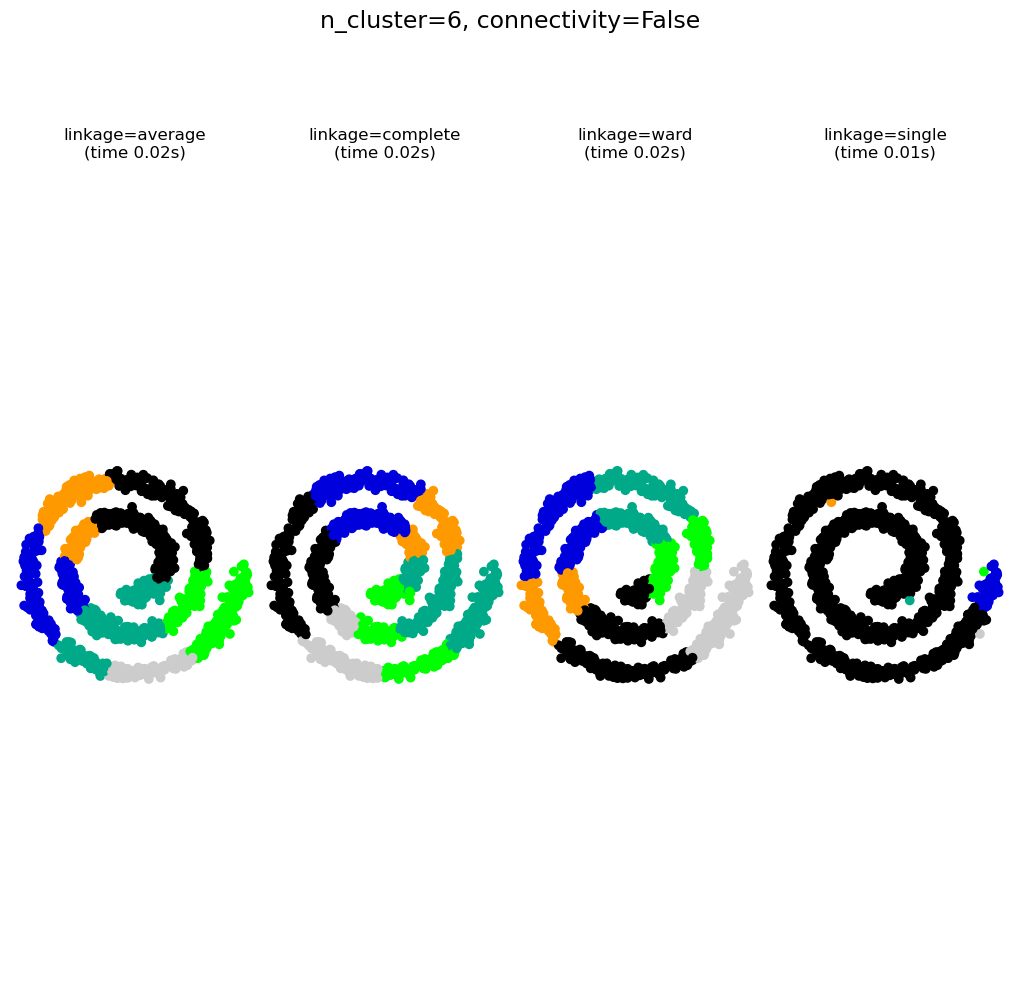

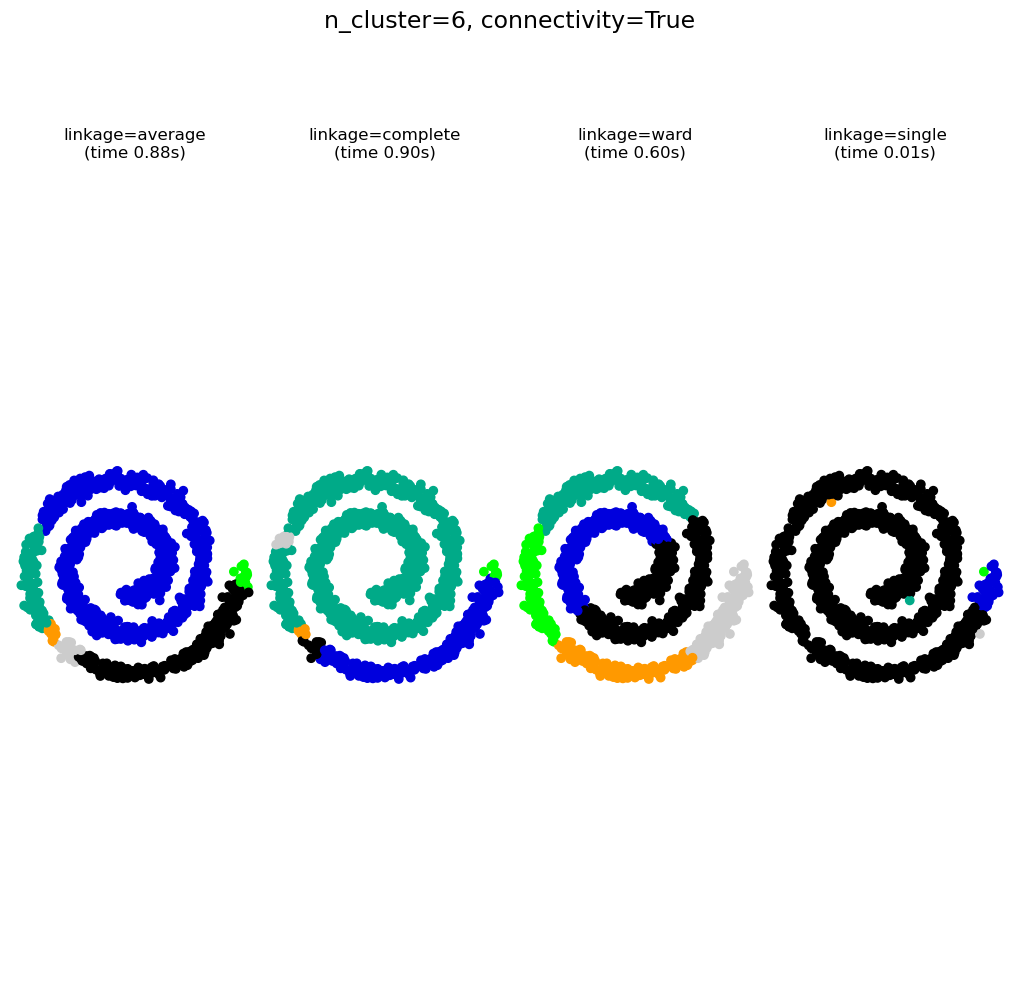

In [21]:
for connectivity in (None, knn_graph):
    plt.figure(figsize=(10, 10))
    for index, linkage in enumerate(("average", "complete", "ward", "single")):
        plt.subplot(1, 4, index + 1)
        model = AgglomerativeClustering(
            linkage=linkage, connectivity=connectivity, n_clusters=n_clusters
        )
        t0 = time.time()
        model.fit(X)
        elapsed_time = time.time() - t0
        plt.scatter(X[:, 0], X[:, 1], c=model.labels_, cmap=plt.cm.nipy_spectral)
        plt.title(
            "linkage=%s\n(time %.2fs)" % (linkage, elapsed_time),
            fontdict=dict(verticalalignment="top"),
        )
        plt.axis("equal")
        plt.axis("off")

    plt.subplots_adjust(bottom=0, top=0.83, wspace=0, left=0, right=1)
    plt.suptitle(
        "n_cluster=%i, connectivity=%r" % (n_clusters, connectivity is not None),
        size=17,
    )


### 运行聚类和画结果
* for connectivity in (None, knn_graph):
    两轮实验
    * 第一轮 connectivity = None, 普通的凝聚层次聚类，不加邻接约束；
    * 第二轮 connectivity = knn_graph ,加上“只能和近邻合并”的图约束；
* plt.figure(figsize = (10,10))
    新建一张大小为10 * 10英寸的画布
    每一轮会画四个子图来对比不同的linkage策略
* for index, linkage in enumerate(("average", "complete", "ward","single")):
    做一个内层循环,尝试四种不同层次聚类“合并策略”（linkage):
    * "average": 两个簇之间的距离定义为（两个簇内所有点对的平均距离）。更平滑一点。

    * "complete": 两个簇之间的距离 = 这两个簇内点对距离的最大值。偏保守，喜欢紧密小团体。

    * "ward": 选择合并后能让簇内方差（内部平方误差和）增加最少的那一对簇。适合欧氏距离的数值特征，常用于连续数据。

    * "single": 两个簇之间的距离 = 簇 A 中任意点和簇 B 中任意点之间的最小距离。这个很容易形成“链式”效果（chaining），会拉出长蛇状的簇。


In [22]:
model = AgglomerativeClustering(
    linkage=linkage, connectivity=connectivity, n_clusters=n_clusters
)
## 创建一个层次聚类模型实例：

##linkage=linkage：用当前这一轮的合并策略（"average"/"complete"/"ward"/"single"）。

##connectivity=connectivity：要么不约束（None），要么使用我们算出来的 kNN 图。

##n_clusters=n_clusters：告诉模型“最后请给我分成 6 类”。

##细节：AgglomerativeClustering 是自底向上的。它一开始有 1500 个小簇（每个点自己是一个簇），然后不断合并，直到只剩下 6 个簇

In [23]:
t0 = time.time()
model.fit(X)
elapsed_time = time.time() - t0

* t0 = time.time() 记录当前时间戳
* model.fit(X) 让模型在数据X上进行聚类。计算树状合并过程并截断到6类
* elapsed_time = time.time() - t0 计算耗时（秒）。

Text(0.5, 1.0, 'linkage=single\n(time 0.01s)')

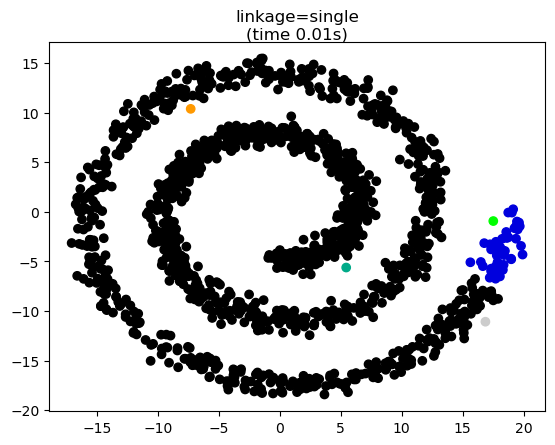

In [24]:
plt.scatter(X[:, 0], X[:, 1], c=model.labels_, cmap=plt.cm.nipy_spectral)
#X[:, 0] 是所有点的 x 坐标；

#X[:, 1] 是所有点的 y 坐标；

#c=model.labels_ 用聚类结果的标签（0,1,2,...）给点上色；

#cmap=plt.cm.nipy_spectral 选择一个颜色映射表，让不同簇用不同颜色显示。
#这一步就是“彩色分簇图可视化”。
plt.title(
    "linkage=%s\n(time %.2fs)" % (linkage, elapsed_time),
    fontdict=dict(verticalalignment="top"),
)
#设置子图标题，显示：
#   使用的linkage类型
#   这个模型拟合用了多少秒

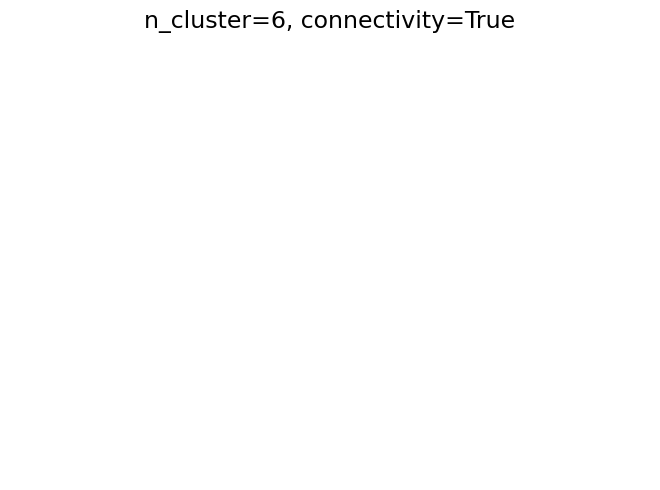

In [25]:
plt.axis("equal")
plt.axis("off")
plt.subplots_adjust(bottom=0, top=0.83, wspace=0, left=0, right=1)
# plt.subplots_adjust(...)
#控制子图之间和整张图边缘的间距：
plt.suptitle(
    "n_cluster=%i, connectivity=%r" % (n_clusters, connectivity is not None),
    size=17,
)
plt.show()
#统一显示全图